# Create the ground truth for policy evaluation

We want a good and a bad policy, and we'll evaluate the mixture of these policies.

At the start of the episode we pick one of the policies with prob `p` (and
the other with prob `1-p`), and stick to it for episode. Repeat and rinse.

We will evaluate different value estimation methods on this mixed policy. We will
see how well they approximate the true value (in the start state) of this mixed policy.
But for this, we need to know the true value of the mixed policy; thankfully this is
easy to calculate in our setting.

Each of these policies is deterministic, and the environment is deterministic. Therefore
we can easily find, by running the policies once, $V^{\pi_g}$, the value of the good policy in the start state, and $V^{\pi_b}$, the value of the bad policy in the start state.

The value of the mixed policy will be $p ^{\pi_g} + (1-p) ^{\pi_b}$.


In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import gymnasium as gym

import adaptive_time.utils
from adaptive_time import run_lib
from adaptive_time import environments
from adaptive_time.mc2 import phi_sa
from adaptive_time.run_lib import make_features

from pprint import pprint

In [2]:
adaptive_time.utils.set_directory_in_project()

Changed working directory to /Users/chanb/research/ualberta/adaptive_time


'/Users/chanb/research/ualberta/adaptive_time'

In [3]:
seed = 13

run_lib.register_gym_envs()
env = gym.make('CartPole-OURS-v0')
env.stepTime(0.02)

run_lib.reset_randomness(seed, env)
phi = run_lib.make_features()

pi_good = np.load('policy_to_eval_good.npy')
pi_bad = np.load('policy_to_eval_bad.npy')

class Policy:
    def __init__(self, sequence_action):
        self.sequence_action = sequence_action
        self.timestep = 0

    def __call__(self, *args, **kwargs):
        action = self.sequence_action[self.timestep]
        self.timestep = (self.timestep + 1) % len(self.sequence_action)
        return action

print('running good policy')
run_lib.reset_randomness(seed, env)
traj_good, early_term = environments.generate_trajectory(env, seed, Policy(pi_good))

print('running bad policy')
run_lib.reset_randomness(seed, env)
traj_bad, early_term = environments.generate_trajectory(env, seed, Policy(pi_bad))


def get_returns(trajectory, x0, gamma = 0.99999):
    returns = []
    G = 0.0
    for t in range(len(trajectory)-1,-1,-1):
        traj = trajectory[t]
        _, _, r, _ = traj
        G = gamma * G + r
        returns.insert(0, G)
    return returns

x0 = phi.get_fourier_feature([0,0,0,0])
returns_good = get_returns(traj_good, x0)
returns_bad = get_returns(traj_bad, x0)

print(returns_good)
print(returns_bad)

running good policy
running bad policy
[13811.823415783701, 13810.961525398954, 13810.099626395217, 13809.23810943041, 13808.376583850346, 13807.51623240488, 13806.655892224657, 13805.797576097137, 13804.939342677948, 13804.084097682942, 13803.229096034893, 13802.371431392306, 13801.514101623206, 13800.660401405521, 13799.807327741055, 13798.959341319014, 13798.112461893477, 13797.272474600486, 13796.434356521897, 13795.605436101974, 13794.779560847774, 13793.949655295082, 13793.109956503315, 13792.267800102478, 13791.418644514628, 13790.561102012163, 13789.700756382925, 13788.83998506513, 13787.978003995815, 13787.11592396752, 13786.254093199706, 13785.392440173324, 13784.532474946405, 13783.672988908203, 13782.816718096146, 13781.961328747608, 13781.103851017482, 13780.247312907706, 13779.389003387303, 13778.531677219322, 13777.672816329978, 13776.814982007249, 13775.955787768457, 13775.097673611566, 13774.23832656301, 13773.380132541051, 13772.520796107232, 13771.662713624779, 13770

/Users/chanb/miniconda3/envs/adaptive_time/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.stepTime to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.stepTime` for environment variables or `env.get_wrapper_attr('stepTime')` that will search the reminding wrappers.
  logger.warn(


In [4]:
pickle.dump(
    {
        "good": {
            "returns": returns_good,
            "trajectory": traj_good,
        },
        "bad": {
            "returns": returns_bad,
            "trajectory": traj_bad,
        },
    }, open("true_value_estimate.pkl", "wb")
)

In [5]:
[obss_good, acts_good, rews_good, _] = [np.array(el) for el in list(zip(*traj_good))]
[obss_bad, acts_bad, rews_bad, _] = [np.array(el) for el in list(zip(*traj_bad))]

print(obss_good.shape, obss_bad.shape)

obss_diff = obss_good[:, None] - obss_bad[None, :]
print(obss_diff.shape)

# This checks which observations are the same between two trajectories
# NOTE: Since we have fixed initial state, we expect just [0, 0] to be the same
print(np.where(np.sum(obss_diff, axis=-1) == 0))

(14874, 4) (37, 4)
(14874, 37, 4)
(array([0]), array([0]))


In [6]:
run_name = "20240301-091719_policy_eval-all_states"
exp_data = pickle.load(open("./exp_results/{}/exp_data.pkl".format(run_name), "rb"))

In [7]:
exp_data["results"]["q0_10"][0].keys()

dict_keys(['total_return', 'total_pivots', 'total_interactions', 'num_episode', 'returns_per_episode_q', 'predicted_returns_q', 'returns_per_episode_v', 'predicted_returns_v', 'all_weights', 'first_actions'])

In [8]:
phi = make_features()

In [9]:
res = {}
for variant in exp_data["results"]:
    print("Processing {}".format(variant))
    res.setdefault(variant, [])
    for run_i in exp_data["results"][variant]:
        res[variant].append([])
        first_actions = np.array(run_i["first_actions"])
        first_action_counts = np.cumsum(first_actions)
        for it_i, weights in enumerate(run_i["all_weights"]):
            rets = []

            for timestep_i, (obs, act, emp_ret) in enumerate(zip(obss_good, acts_good, returns_good)):
                x_sa = phi_sa(phi.get_fourier_feature(obs), act)
                pred_ret = x_sa.flatten() @ weights
                rets.append([pred_ret, emp_ret])

            for timestep_i, (obs, act, emp_ret) in enumerate(zip(obss_bad, acts_bad, returns_bad)):
                x_sa = phi_sa(phi.get_fourier_feature(obs), act)
                pred_ret = x_sa.flatten() @ weights
                if timestep_i > 0:
                    rets.append([pred_ret, emp_ret])
                else:
                    # estimate is based on number of first action seen
                    first_action_weight = first_action_counts[it_i] / (it_i + 1)
                    rets[0][0] = first_action_weight * rets[0][0] + (1 - first_action_weight) * pred_ret

                    # empirical return is half of each
                    rets[0][1] = 0.5 * rets[0][1] + 0.5 * emp_ret
            res[variant][-1].append([
                it_i, np.array(rets)
            ])

Processing q0_10
Processing q0_5
Processing q0_1
Processing u5
Processing u10
Processing u20


In [10]:
pickle.dump(
    res, open("v_estimates_all_states.pkl", "wb")
)

In [11]:
print(res.keys())

dict_keys(['q0_10', 'q0_5', 'q0_1', 'u5', 'u10', 'u20'])


Processing q0_10
Processing q0_5
Processing q0_1
Processing u5
Processing u10
Processing u20


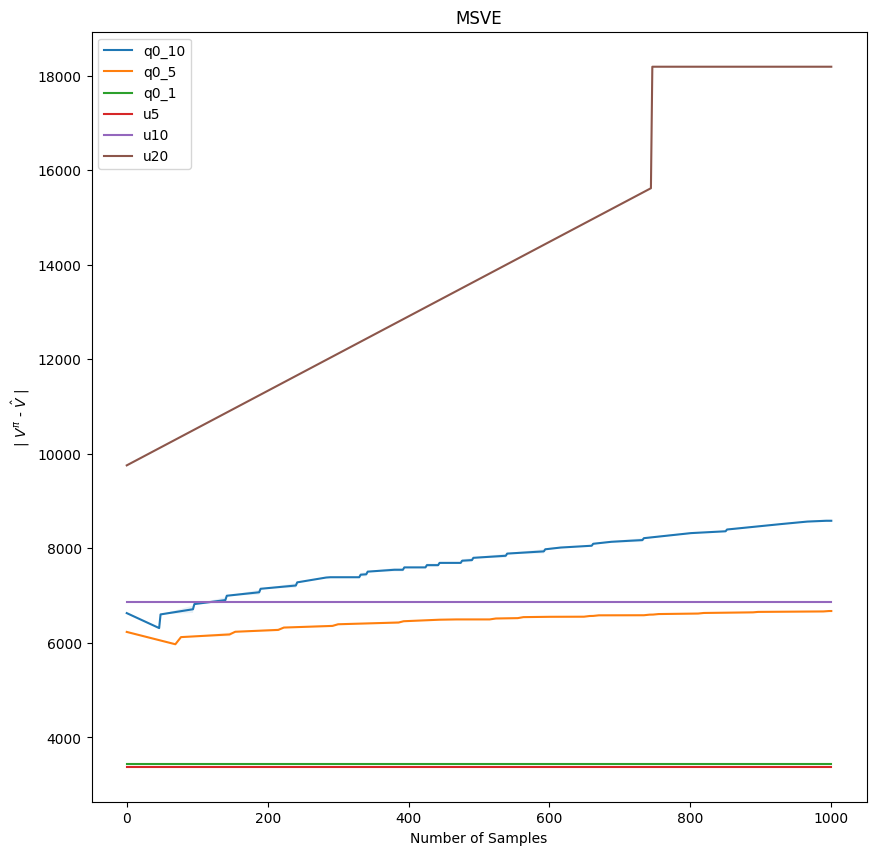

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

budget = exp_data["config"]["budget"]
for variant, runs in res.items():
    print("Processing {}".format(variant))

    interpolated_results = np.zeros((len(runs), budget + 1))
    for run_i, res_data in enumerate(runs):
        res_data = list(zip(*res_data))
        rets = np.array(res_data[1])

        length = min(len(exp_data["results"][variant][run_i]["total_pivots"]), len(rets))

        interpolated_results[run_i] = np.interp(
            np.arange(budget + 1),
            exp_data["results"][variant][run_i]["total_pivots"][:length],
            np.mean((np.abs(rets[..., 0] - rets[..., 1])), axis=-1)[:length]
        )

    y_means = np.nanmean(interpolated_results, axis=0)
    y_stderrs =  np.nanstd(interpolated_results, axis=0) / np.sqrt(len(runs))
    ax.plot(np.arange(budget + 1), y_means, label=variant)
    ax.fill_between(np.arange(budget + 1), y_means - y_stderrs, y_means + y_stderrs, alpha=0.1)


ax.legend()
ax.set_xlabel("Number of Samples")
ax.set_ylabel("| $V^\pi$ - $\hat V$ |")
ax.set_title("MSVE")
plt.show()
        

Processing q0_10
Processing q0_5
Processing q0_1
Processing u5
Processing u10
Processing u20


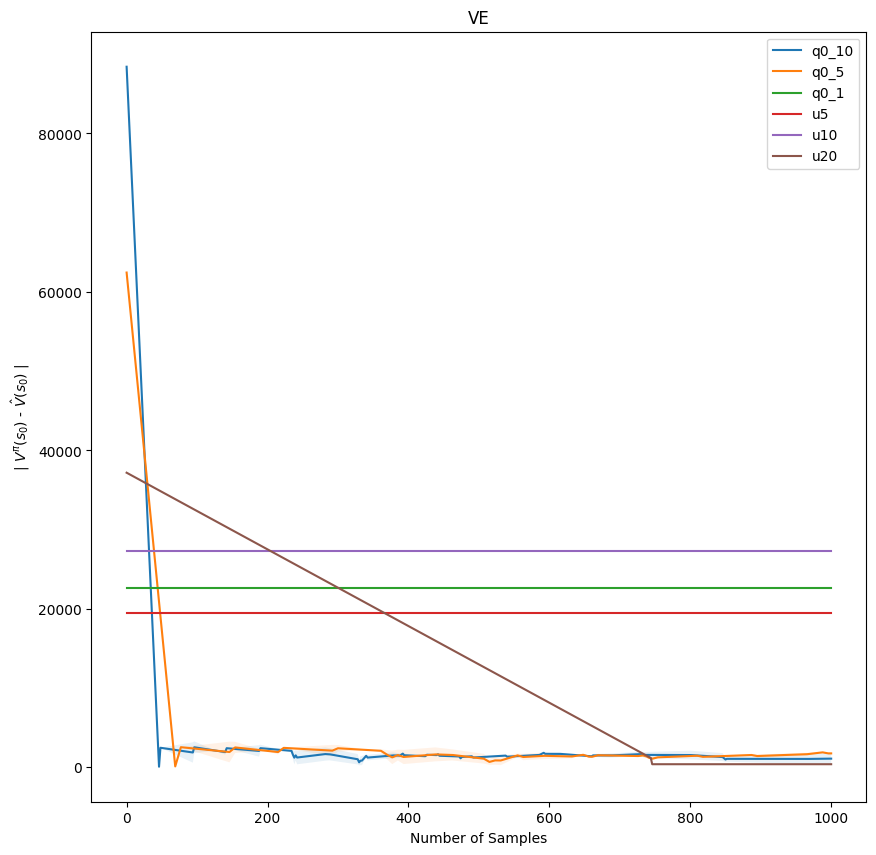

Processing q0_10
Processing q0_5
Processing q0_1
Processing u5
Processing u10
Processing u20


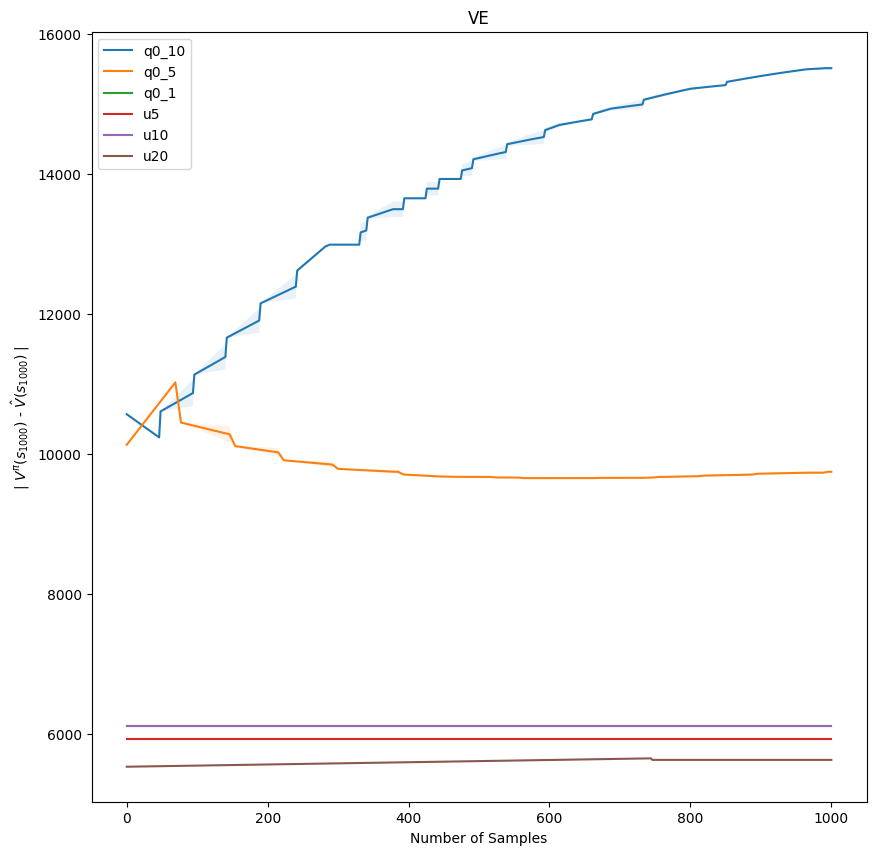

Processing q0_10
Processing q0_5
Processing q0_1
Processing u5
Processing u10
Processing u20


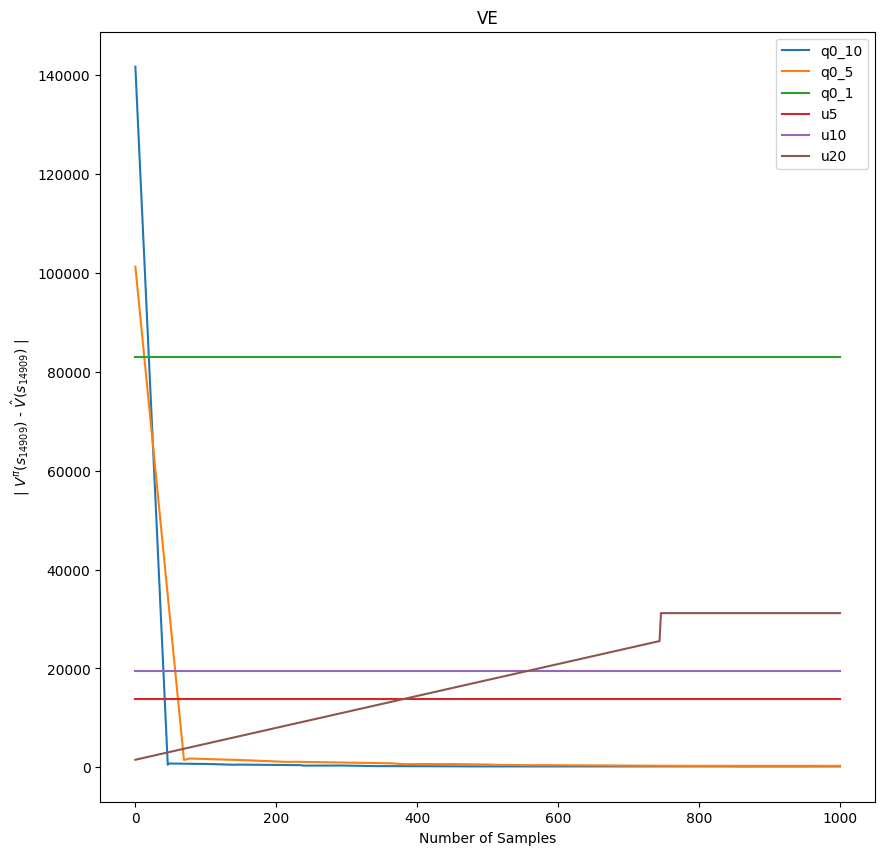

In [31]:
budget = exp_data["config"]["budget"]

total_num_timesteps = len(obss_good) + len(obss_bad) - 1
timesteps_to_check = [0, 1000, total_num_timesteps - 1]

for timestep in timesteps_to_check:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for variant, runs in res.items():
        print("Processing {}".format(variant))

        interpolated_results = np.zeros((len(runs), budget + 1))
        for run_i, res_data in enumerate(runs):
            res_data = list(zip(*res_data))
            rets = np.array(res_data[1])

            length = min(len(exp_data["results"][variant][run_i]["total_pivots"]), len(rets))

            interpolated_results[run_i] = np.interp(
                np.arange(budget + 1),
                exp_data["results"][variant][run_i]["total_pivots"][:length],
                np.abs(rets[:, timestep, 0] - rets[:, timestep, 1])[:length]
            )

        y_means = np.nanmean(interpolated_results, axis=0)
        y_stderrs =  np.nanstd(interpolated_results, axis=0) / np.sqrt(len(runs))
        ax.plot(np.arange(budget + 1), y_means, label=variant)
        ax.fill_between(np.arange(budget + 1), y_means - y_stderrs, y_means + y_stderrs, alpha=0.1)

    ax.legend()
    ax.set_xlabel("Number of Samples")
    ax.set_ylabel("| $V^\pi(s_{{{timestep}}})$ - $\hat V(s_{{{timestep}}})$ |".format(timestep=timestep))
    ax.set_title("VE")
    plt.show()
